In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/processed/Los_Angeles_Accidents_Agreagated_2016_2023.csv')

In [4]:
data.head()

,Accident_Date,Severity,Temperature(F),Weather_Condition,Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),accident_weekday,is_weekend,is_holiday,Accident_Year,Accident_Month,Accident_Day,total_accidents
0,2016-03-22,2.400000,63.040000,Clear,26.000000,30.016000,10.000000,9.680000,0.003435,1,False,False,2016,3,22,5
1,2016-03-23,2.529412,68.491176,Clear,29.794118,30.114559,10.000000,5.885718,0.003435,2,False,False,2016,3,23,68
2,2016-03-24,2.485294,68.372059,Clear,33.544118,30.008235,9.870588,5.265365,0.003435,3,False,False,2016,3,24,68
3,2016-03-25,2.533333,65.831111,Clear,56.088889,29.824444,10.000000,4.864368,0.003435,4,False,False,2016,3,25,45
4,2016-03-26,2.736842,64.394737,Clear,70.631579,29.853158,9.842105,6.060947,0.003435,5,True,False,2016,3,26,19


In [5]:
x = data.drop(columns=['Accident_Date', 'Severity', 'Accident_Year', 'Accident_Day', 'total_accidents'])
y = data['total_accidents']

In [6]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2493 entries, 0 to 2492
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature(F)     2493 non-null   float64
 1   Weather_Condition  2493 non-null   object 
 2   Humidity(%)        2493 non-null   float64
 3   Pressure(in)       2493 non-null   float64
 4   Visibility(mi)     2493 non-null   float64
 5   Wind_Speed(mph)    2493 non-null   float64
 6   Precipitation(in)  2493 non-null   float64
 7   accident_weekday   2493 non-null   int64  
 8   is_weekend         2493 non-null   bool   
 9   is_holiday         2493 non-null   bool   
 10  Accident_Month     2493 non-null   int64  
dtypes: bool(2), float64(6), int64(2), object(1)
memory usage: 180.3+ KB


In [7]:
cat_cols = ['Weather_Condition', 'accident_weekday', 'is_weekend', 'is_holiday', 'Accident_Month']
num_cols = x.columns.drop(cat_cols)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [9]:
pipe_num = Pipeline([
    ('scaler', RobustScaler())
])
pipe_cat = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='infrequent_if_exist'))
])
preproc = ColumnTransformer([
    ('num_transforms', pipe_num, num_cols),
    ('cat_transforms', pipe_cat, cat_cols)
])

In [10]:
pipe = Pipeline([
    ('preprocessing', preproc),
    # ('regressor', MLPRegressor()
    # ('regressor', RandomForestRegressor())
    ('regressor', KNeighborsRegressor())
])
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  Index(['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Speed(mph)', 'Precipitation(in)'],
      dtype='object')),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequent_if_exist'))]),
                                                  ['Weather_Condition',
                                                   'accident_weekday',
                                                   'is_weekend', 'is_holiday',
                                                   'Accident_Month'])])),
                ('regressor', KNeighborsRegressor())])

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [12]:
res_dict = cross_validate(pipe, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

c:\Users\IbrahimAssi\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\IbrahimAssi\.conda\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [13]:
res = pd.DataFrame(res_dict)
res.sort_values('test_score')

,fit_time,score_time,test_score
2,0.048786,0.080030,-31.135155
1,0.039340,0.080211,-30.130754
4,0.036522,0.099999,-30.036597
0,0.064730,0.087466,-29.343461
3,0.040366,0.071694,-29.224753


In [14]:
res.mean()

fit_time       0.045949
score_time     0.083880
test_score   -29.974144
dtype: float64

In [15]:
from sklearn.metrics import root_mean_squared_error, PredictionErrorDisplay
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
performance_metrics = {
    'root_mean_squared_error': root_mean_squared_error(y_test, y_pred)
}
performance_metrics

{'root_mean_squared_error': 31.468337619662883}

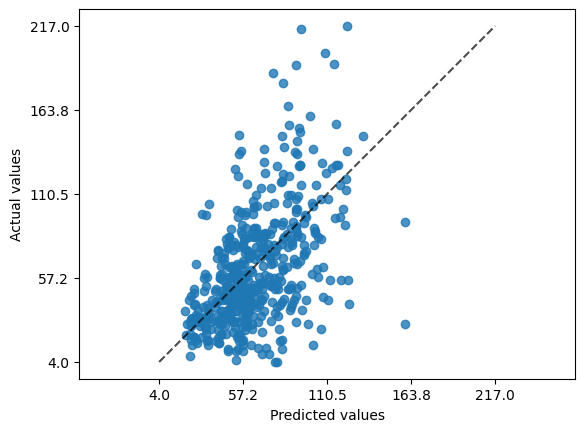

In [16]:
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred, kind='actual_vs_predicted')

In [17]:
x_transform = pipe.named_steps['preprocessing'].transform(x)
x_transform = x_transform.toarray()
x_transform.shape

(2493, 40)

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_transform, y, test_size=0.2, random_state=42)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers

In [108]:
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(40,)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 20)                820       
                                                                 
 dense_31 (Dense)            (None, 1)                 21        
                                                                 
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


In [109]:
model.compile(
    loss='mse',
    optimizer=optimizers.Adam(learning_rate=0.01),
    metrics=['RootMeanSquaredError']
)

In [110]:
callback = EarlyStopping(patience=5)

In [111]:
history = model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=250,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/1000
7/7 [==============================] - 2s 92ms/step - loss: 5120.1519 - root_mean_squared_error: 71.5552 - val_loss: 5321.4487 - val_root_mean_squared_error: 72.9483
Epoch 2/1000
7/7 [==============================] - 0s 21ms/step - loss: 4976.1797 - root_mean_squared_error: 70.5420 - val_loss: 5152.4443 - val_root_mean_squared_error: 71.7805
Epoch 3/1000
7/7 [==============================] - 0s 21ms/step - loss: 4787.3613 - root_mean_squared_error: 69.1908 - val_loss: 4908.9194 - val_root_mean_squared_error: 70.0637
Epoch 4/1000
7/7 [==============================] - 0s 21ms/step - loss: 4518.0635 - root_mean_squared_error: 67.2165 - val_loss: 4571.5151 - val_root_mean_squared_error: 67.6130
Epoch 5/1000
7/7 [==============================] - 0s 19ms/step - loss: 4163.8428 - root_mean_squared_error: 64.5278 - val_loss: 4137.9033 - val_root_mean_squared_error: 64.3265
Epoch 6/1000
7/7 [==============================] - 0s 19ms/step - loss: 3713.6980 - root_mean_squared_er

In [112]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 5ms/step - loss: 863.0707 - root_mean_squared_error: 29.3781


[863.0707397460938, 29.37806510925293]

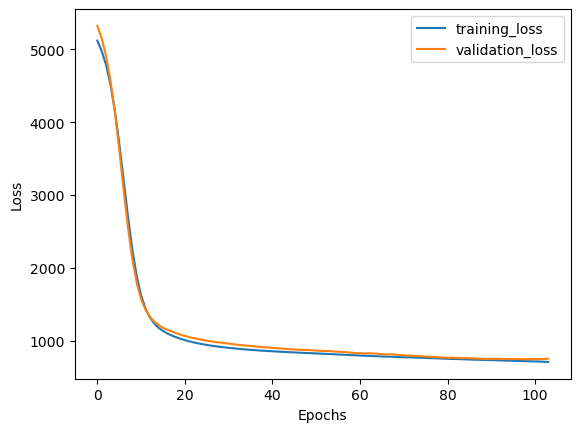

In [113]:
plt.plot(history.history["loss"], label="training_loss")
plt.plot(history.history["val_loss"], label="validation_loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

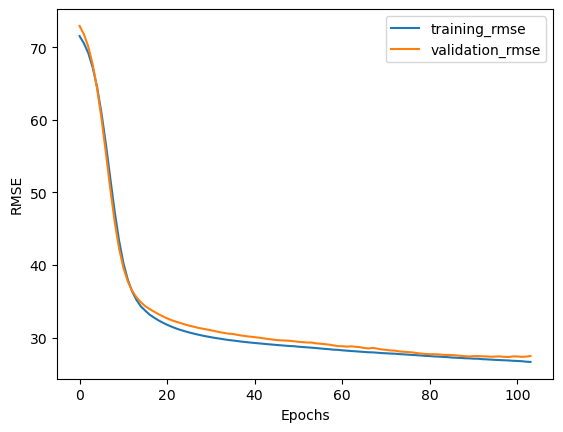

In [114]:
plt.plot(history.history["root_mean_squared_error"], label="training_rmse")
plt.plot(history.history["val_root_mean_squared_error"], label="validation_rmse")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.show()

16/16 [==============================] - 0s 3ms/step


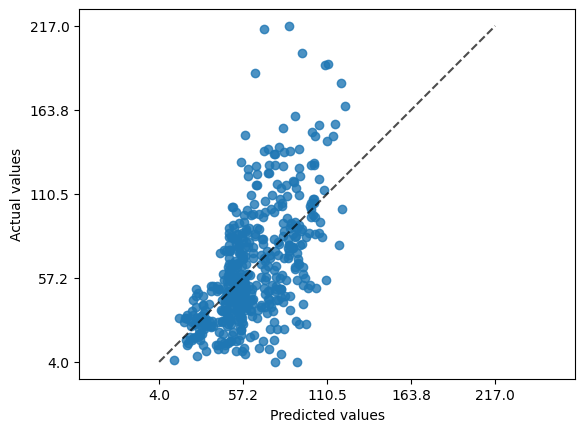

In [115]:
y_pred = model.predict(x_test)
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred, kind='actual_vs_predicted')

In [119]:
import shap
explainer = shap.KernelExplainer(
    model.predict,
    x_test,
    feature_names = pipe.named_steps['preprocessing'].get_feature_names_out()
    )

16/16 [==============================] - 0s 8ms/step


Using 499 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [124]:
shap_values = explainer(shap.sample(x_test, 10))

  0%|          | 0/10 [00:00<?, ?it/s]

33059/33059 [==============================] - 111s 3ms/step


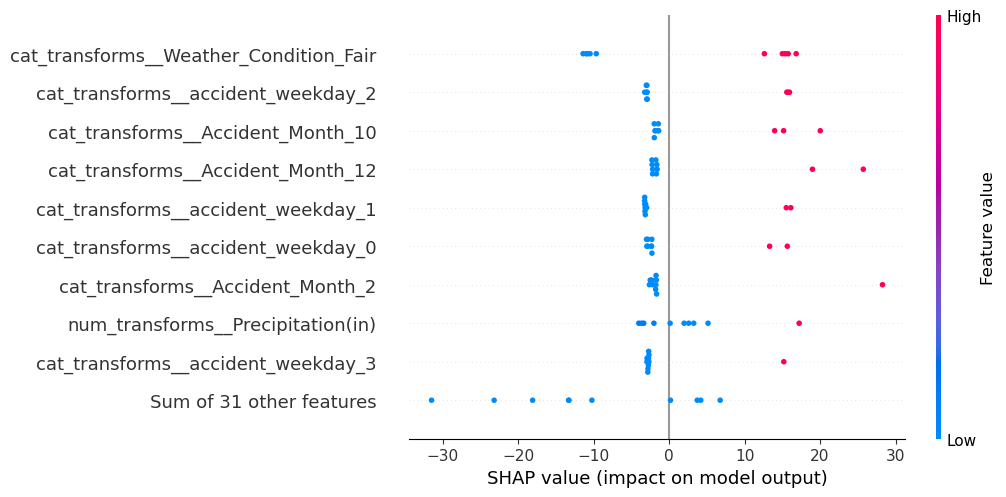

In [142]:
shap.plots.beeswarm(shap_values[:,:,0])